# What makes a good book?
![](img/books_pattern.jpg)

*A [DataCamp](https://datacamp.com) challenge* &nbsp;&nbsp;&nbsp;&nbsp;{octicon}`calendar` Feb, 2025  

{bdg-secondary-line}`Classification`

## The project
Build a model that accurately predicts book popularity, which will help a bookstore manage their stock better and tweak their marketing plans to suit what their readers love the most.

## The data
| Column     | Description              |
|------------|--------------------------|
| `'title'` | Book title. |
| `'price'` | Book price. |
| `'review/helpfulness'` | The number of helpful reviews over the total number of reviews. | 
| `'review/summary'` | The summary of the review. |
| `'review/text'`| The review's full text. |
| `'description'` | The book's description. |
| `'authors'` | Author. | 
| `'categories'` | Book categories. |
| `'popularity'` | Whether the book was popular or unpopular. | 

## Data validation
### Read the data

In [1]:
# Import packages
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import TargetEncoder
from nltk import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Read the data
books = pd.read_csv("data/books.csv")
books

,title,price,review/helpfulness,review/summary,review/text,description,authors,categories,popularity
0,We Band of Angels: The Untold Story of America...,10.88,2/3,A Great Book about women in WWII,I have alway been a fan of fiction books set i...,"In the fall of 1941, the Philippines was a gar...",'Elizabeth Norman','History',Unpopular
1,Prayer That Brings Revival: Interceding for Go...,9.35,0/0,Very helpful book for church prayer groups and...,Very helpful book to give you a better prayer ...,"In Prayer That Brings Revival, best-selling au...",'Yong-gi Cho','Religion',Unpopular
2,The Mystical Journey from Jesus to Christ,24.95,17/19,Universal Spiritual Awakening Guide With Some ...,The message of this book is to find yourself a...,THE MYSTICAL JOURNEY FROM JESUS TO CHRIST Disc...,'Muata Ashby',"'Body, Mind & Spirit'",Unpopular
3,Death Row,7.99,0/1,Ben Kincaid tries to stop an execution.,The hero of William Bernhardt's Ben Kincaid no...,"Upon receiving his execution date, one of the ...",'Lynden Harris','Social Science',Unpopular
4,Sound and Form in Modern Poetry: Second Editio...,32.50,18/20,good introduction to modern prosody,There's a lot in this book which the reader wi...,An updated and expanded version of a classic a...,"'Harvey Seymour Gross', 'Robert McDowell'",'Poetry',Unpopular
...,...,...,...,...,...,...,...,...,...
15714,Attack of the Deranged Mutant Killer Monster S...,7.64,0/0,Great for Calvin lovers,"Bought as a Christmas gift, great book for kin...",Online: gocomics.com/calvinandhobbes/,'Bill Watterson','Comics & Graphic Novels',Unpopular
15715,Book Savvy,33.99,2/2,literary pleasure,I thoroughly enjoyed Ms. Katona's Book Savvy. ...,"Recounts the adventures of Mibs Beaumont, whos...",'Ingrid Law','Juvenile Fiction',Popular
15716,Organizing to Win: New Research on Union Strat...,24.95,3/4,Great Book for Union Organizers!,This is a good reference tool for Union Organi...,As the American labour movement mobilizes for ...,"'Kate Bronfenbrenner', 'Sheldon Friedman', 'Ri...",'Business & Economics',Popular
15717,The Dharma Bums,39.95,3/3,"The Sad, Beautiful, Joyful World of Jack Kerouac",Jack Kerouac was intensely alive and his fiery...,THE DHARMA BUMS appeared just one year after t...,'Jack Kerouac','Fiction',Popular


### Check data quality

#### Missing values

In [2]:
# Get df info
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15719 entries, 0 to 15718
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               15719 non-null  object 
 1   price               15719 non-null  float64
 2   review/helpfulness  15719 non-null  object 
 3   review/summary      15718 non-null  object 
 4   review/text         15719 non-null  object 
 5   description         15719 non-null  object 
 6   authors             15719 non-null  object 
 7   categories          15719 non-null  object 
 8   popularity          15719 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


There is only one missing values, I will drop that row.

In [3]:
# Drop missing values
books.dropna(inplace=True)

#### Duplicated values

In [4]:
# Check on all columns
print(f"Duplicated rows -> {books.duplicated().sum()}")

Duplicated rows -> 3294


I will drop all duplicated records.

In [5]:
# Drop duplicated rows
books.drop_duplicates(inplace=True)

### Check value ranges
#### Categorical data
Let's see value ranges in categorical data columns `authors` and `categories`, and the balance of the target variable `popularity`.

In [6]:
# Print number of unique values
print(f"Number of unique 'authors' -> {books["authors"].nunique()}")
print(f"Number of unique 'categories' -> {books["categories"].nunique()}")

Number of unique 'authors' -> 6447
Number of unique 'categories' -> 313


We can see that these categorical columns, especially "authors", have lots of unique values ("high cardinality").

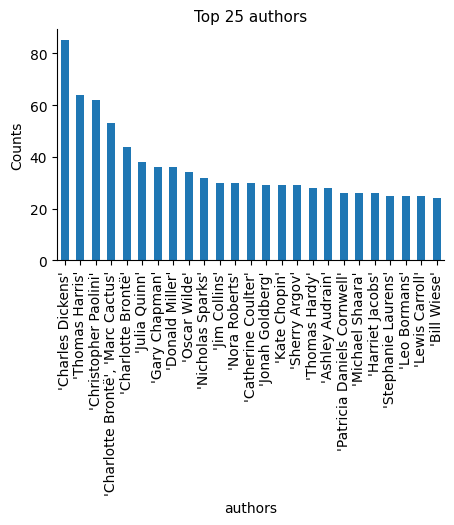

In [7]:
# Plot the counting of top authors
n_top = 25
fig, ax = plt.subplots(figsize=(5, 3))
books["authors"].value_counts()[:n_top].plot(ax=ax, kind="bar")
ax.set_title(f"Top {n_top} authors", fontsize=11)
ax.set_ylabel("Counts")
sns.despine()
plt.show()

We also observe that some authors consist of more than one name, separated by a comma, as seen in the case of 'Charlotte Brontë, Marc Cactus' in the 4th position, and also 'Charlotte Brontë' in the 5th position.

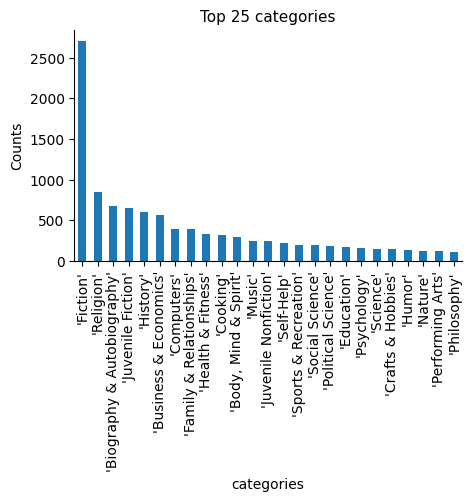

In [8]:
# Plot the counting of top authors
n_top = 25
fig, ax = plt.subplots(figsize=(5, 3))
books["categories"].value_counts()[:n_top].plot(ax=ax, kind="bar")
ax.set_title(f"Top {n_top} categories", fontsize=11)
ax.set_ylabel("Counts")
sns.despine()
plt.show()

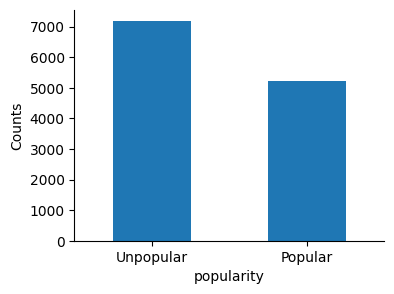

In [9]:
# Plot popularity counts
fig, ax = plt.subplots(figsize=(4, 3))
books["popularity"].value_counts().plot(ax=ax, kind="bar")
ax.tick_params(axis="x", labelsize=10, rotation=0)
ax.set_ylabel("Counts")
sns.despine()
plt.show()

#### Numerical data

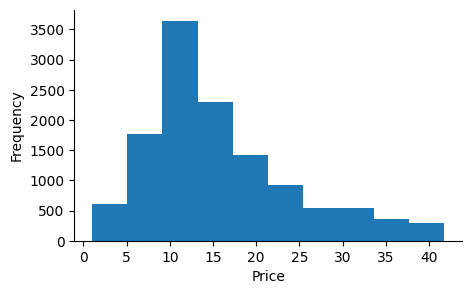

In [10]:
# Plot prices' histogram
fig, ax = plt.subplots(figsize=(5, 3))
books["price"].plot(ax=ax, kind="hist")
ax.set_xlabel("Price")
sns.despine()
plt.show()

### Data preprocessing

#### Split "review/helpfulness"
"review/helpfulness" column can be split into two different columns: "helpful_reviews" and "total_reviews".

In [11]:
# Split strings around "/" separator, and convert new columns to numerical integer
books[["helpful_reviews", "total_reviews"]] = (
    books["review/helpfulness"].str.split("/", expand=True).astype("int")
)

# Show result in first rows
books[["review/helpfulness", "helpful_reviews", "total_reviews"]].head()

,review/helpfulness,helpful_reviews,total_reviews
0,2/3,2,3
1,0/0,0,0
2,17/19,17,19
3,0/1,0,1
4,18/20,18,20


In [12]:
# Drop processed column
books.drop(["review/helpfulness"], axis=1, inplace=True)

#### Sentiment analysis in review texts
I will apply sentiment analysis to get a polarity score (between [-1, 1], with "-1" negative, "0" neutral, "1" positive) in "review/summary" and "review/text" columns.

In [13]:
# Download the VADER lexicon
nltk.download("vader_lexicon", quiet=True)

# Instanciate sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Apply to review summary and text columns creating new features
books["review_sum_sent"] = books["review/summary"].apply(
    lambda text: sentiment_analyzer.polarity_scores(text)["compound"]
)
books["review_text_sent"] = books["review/text"].apply(
    lambda text: sentiment_analyzer.polarity_scores(text)["compound"]
)

# Show result in first rows
books[["review/summary", "review_sum_sent", "review/text", "review_text_sent"]].head()

,review/summary,review_sum_sent,review/text,review_text_sent
0,A Great Book about women in WWII,0.6249,I have alway been a fan of fiction books set i...,0.8482
1,Very helpful book for church prayer groups and...,0.4754,Very helpful book to give you a better prayer ...,0.8955
2,Universal Spiritual Awakening Guide With Some ...,0.0000,The message of this book is to find yourself a...,0.9155
3,Ben Kincaid tries to stop an execution.,-0.2960,The hero of William Bernhardt's Ben Kincaid no...,-0.2582
4,good introduction to modern prosody,0.4404,There's a lot in this book which the reader wi...,0.9571


Is there a positive correlation between the review text score and the summary sentiment score?

In [14]:
# Check correlation
corr = books["review_sum_sent"].corr(books["review_text_sent"])
print(f"\n{corr:.2f} <- correlation between sentiment in review summary and text")


0.26 <- correlation between sentiment in review summary and text


Scarce correlation. So I will leave it like that, without merging them in an average value.

#### Word tokenize review texts
I will compute the number of words-tokens in the review texts, this value may capture the interest the book has received.

In [15]:
# Download nltk necessary package
nltk.download("punkt_tab", quiet=True)

# Apply tokenizer to the column, creating a new one with the value
books["review_text_ntokens"] = books["review/text"].apply(
    lambda text: len(word_tokenize(text))
)

# Show result in first rows
books[["review/text", "review_text_ntokens"]].head()

,review/text,review_text_ntokens
0,I have alway been a fan of fiction books set i...,105
1,Very helpful book to give you a better prayer ...,25
2,The message of this book is to find yourself a...,1375
3,The hero of William Bernhardt's Ben Kincaid no...,430
4,There's a lot in this book which the reader wi...,407


#### Split authors' names
We saw earlier that some authors are composed by more than one name separated by comma. For example:

In [16]:
# Filter records that contain comma and show first
books.loc[books["authors"].str.contains(", "), ["authors"]].head(1)

,authors
4,"'Harvey Seymour Gross', 'Robert McDowell'"


To differentiate them, I will split the names by the comma.

In [17]:
# Split column by comma resulting in list
books["authors"] = books["authors"].str.split(", ")

# Show result in first rows
books[["authors"]].head()

,authors
0,['Elizabeth Norman']
1,['Yong-gi Cho']
2,['Muata Ashby']
3,['Lynden Harris']
4,"['Harvey Seymour Gross', 'Robert McDowell']"


And then I will "explode" this column now composed by lists, transforming each element to a row, replicating index values.

In [18]:
# Explode in the "authors" column
books = books.explode("authors")

# Show result in first rows
books[["authors"]].head(6)

,authors
0,'Elizabeth Norman'
1,'Yong-gi Cho'
2,'Muata Ashby'
3,'Lynden Harris'
4,'Harvey Seymour Gross'
4,'Robert McDowell'


Author names are now untangled.

#### Lowercase categories
Adjust book categories to lowercase, because some of the entries were repeated in uppercase.

In [19]:
# Show some of the categories in uppercase
books.loc[books["categories"].str.isupper(), ["categories"]][:10]

,categories
576,'SAP R/3'
1009,'FAMILY & RELATIONSHIPS'
1009,'FAMILY & RELATIONSHIPS'
1801,'COMICS & GRAPHIC NOVELS.'
1812,'FICTION'
1895,'LANGUAGE ARTS & DISCIPLINES'
1895,'LANGUAGE ARTS & DISCIPLINES'
1895,'LANGUAGE ARTS & DISCIPLINES'
2119,'BIOGRAPHY & AUTOBIOGRAPHY'
2205,'SAP R/3'


In [20]:
# Convert all categories to lowercase
books["categories"] = books["categories"].str.lower()

#### Convert data types

- I will replace the target variable "popularity" from "Popular" and "Unpopular" to numerical values "0" and "1".
- I will convert "authors" and "categories" to categorical data types.
- I will drop unnecessary columns for the project: "title", "description", "review/summary", "review/text".

In [21]:
# Replace target variable from category to numerical value
books["popularity"] = books["popularity"].apply(
    lambda popularity: 1 if popularity == "Popular" else 0
)

# Apply conversion to categorical
books[["authors", "categories"]] = books[["authors", "categories"]].astype("category")

# Drop unnecessary columns
books.drop(
    ["title", "description", "review/summary", "review/text"], axis=1, inplace=True
)

# Show dataframe info
books.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15275 entries, 0 to 15718
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   price                15275 non-null  float64 
 1   authors              15275 non-null  category
 2   categories           15275 non-null  category
 3   popularity           15275 non-null  int64   
 4   helpful_reviews      15275 non-null  int32   
 5   total_reviews        15275 non-null  int32   
 6   review_sum_sent      15275 non-null  float64 
 7   review_text_sent     15275 non-null  float64 
 8   review_text_ntokens  15275 non-null  int64   
dtypes: category(2), float64(3), int32(2), int64(2)
memory usage: 1.2 MB


We are now ready to test a model for classification.

## Classifier

I will define target and features:

In [22]:
# Define target
target = books["popularity"]

# Define the features
features = books.drop("popularity", axis=1)
features.head()

,price,authors,categories,helpful_reviews,total_reviews,review_sum_sent,review_text_sent,review_text_ntokens
0,10.88,'Elizabeth Norman','history',2,3,0.6249,0.8482,105
1,9.35,'Yong-gi Cho','religion',0,0,0.4754,0.8955,25
2,24.95,'Muata Ashby',"'body, mind & spirit'",17,19,0.0000,0.9155,1375
3,7.99,'Lynden Harris','social science',0,1,-0.2960,-0.2582,430
4,32.50,'Harvey Seymour Gross','poetry',18,20,0.4404,0.9571,407


I will also define a function, based on a Logistic Regression model, that will be used several times later.

In [23]:
def lg_classifier(X_train, X_test, y_train, y_test):
    """Logistic Regression classifier"""

    # Scale
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

    # Instantiate model
    model = LogisticRegression()

    # Fit model to the training set
    model.fit(X_train_scaled, y_train)

    # Predict test set values
    y_pred = model.predict(X_test_scaled)

    # Print results
    print(f"{accuracy_score(y_test, y_pred):.2f} <- Test-set accuracy ")
    print(
        f"{accuracy_score(y_train, model.predict(X_train_scaled)):.2f} <- Train-set accuracy "
    )

    return model, y_pred

### 1) One-hot encoding

The first approach will be to one-hot encode "authors" and "categories":

In [24]:
# Get dummies for features
features_dummied = pd.get_dummies(features, drop_first=True, dtype="int")
features_dummied.shape

(15275, 8368)

Due to the high cardinality, it gives us a huge amount of columns. That will probably overfit the model. Let's check it out.

In [25]:
# Assign target a features
y = target
X = features_dummied

# Split dataset into training and test set, and stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

_, _ = lg_classifier(X_train, X_test, y_train, y_test)

0.63 <- Test-set accuracy 
0.88 <- Train-set accuracy 


Indeed, it overfits the logistic regression model.  

What if we drop categories and use only numeric features?

In [26]:
# Define features
features = books.drop(["popularity", "authors", "categories"], axis=1)

# Assign target a features
y = target
X = features

# Split dataset into training and test set, and stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

_, _ = lg_classifier(X_train, X_test, y_train, y_test)

0.64 <- Test-set accuracy 
0.63 <- Train-set accuracy 


The model here is not overfitting, confirming the previous problem of the high dimensionality.

Let's see if we can improve these results.

### 2) Grouping together rare categories
To reduce the dimensionality, let's group rare authors and rare book categories into a new category name called "other".

First I will consider a cutoff value to rename a rare author as "other".

In [27]:
# Count how many times an author appears
authors_by_freq = books["authors"].value_counts()

# Define a cutoff value to consider an author as rare
freq_cutoff_a = 5

# Create a list of rare (scarce) authors
rare_authors = [
    author for author, freq in authors_by_freq.items() if freq <= freq_cutoff_a
]

# Create a new "authors" feature where rare authors are grouped into a group called "other"
books["authors_rare_grouped"] = books["authors"].apply(
    lambda author: "other" if author in rare_authors else author
)

# Show results in first rows
books[["authors", "authors_rare_grouped"]].head()

,authors,authors_rare_grouped
0,'Elizabeth Norman','Elizabeth Norman'
1,'Yong-gi Cho',other
2,'Muata Ashby',other
3,'Lynden Harris',other
4,'Harvey Seymour Gross',other


In [28]:
# Count unique authors
print(f"Number of unique authors -> {books["authors_rare_grouped"].nunique()}")

Number of unique authors -> 311


I will do the same with book categories:

In [29]:
# Count how many times a category appears
categories_by_freq = books["categories"].value_counts()

# Define a cutoff value to consider a category as rare
freq_cutoff_c = 2

# Create a list of rare_categories with cutoff
rare_categories = [category for category, freq in categories_by_freq.items() if freq <= freq_cutoff_c]

# Create a new "categories" feature where rare categories are grouped into a group called "other"
books["categories_rare_grouped"] = books["categories"].apply(lambda category: "other" if category in rare_categories else category)

# Count unique categories
print(f"Number of unique categories -> {books["categories_rare_grouped"].nunique()}")

Number of unique categories -> 121


Let's model it with one-hot encoding:

In [30]:
# Define features
features = books.drop(["popularity", "authors", "categories"], axis=1)

# Get dummies for features
features_dummied = pd.get_dummies(features, drop_first=True, dtype="int")

# Assign target a features
y = target
X = features_dummied

# Split dataset into training and test set, and stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

_, _ = lg_classifier(X_train, X_test, y_train, y_test)

0.65 <- Test-set accuracy 
0.67 <- Train-set accuracy 


It doesn't overfit now!

Let's see if we can further improve results with another approach to deal with categories.

### 3) Target encoding
Let's transform categorical columns by their target encoding value. It is important to fit the encoding only with training values because otherwise this technique is very prone to data-leakage caused result distortion.

In [31]:
# Assign target a features
y = target
X = features

# Split dataset into training and test set, and stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Initialize TargetEncoder
encoder = TargetEncoder()

# Create new features with encoded values
X_train[["authors_enc", "categories_enc"]] = encoder.fit_transform(
    X_train[["authors_rare_grouped", "categories_rare_grouped"]], y_train
)
X_test[["authors_enc", "categories_enc"]] = encoder.transform(
    X_test[["authors_rare_grouped", "categories_rare_grouped"]]
)

# Drop columns
X_train.drop(["authors_rare_grouped", "categories_rare_grouped"], axis=1, inplace=True)
X_test.drop(["authors_rare_grouped", "categories_rare_grouped"], axis=1, inplace=True)

# Classify
model, y_pred = lg_classifier(X_train, X_test, y_train, y_test)
print(classification_report(y_test, y_pred))

0.66 <- Test-set accuracy 
0.66 <- Train-set accuracy 
              precision    recall  f1-score   support

           0       0.68      0.77      0.72      2649
           1       0.62      0.51      0.56      1934

    accuracy                           0.66      4583
   macro avg       0.65      0.64      0.64      4583
weighted avg       0.66      0.66      0.65      4583



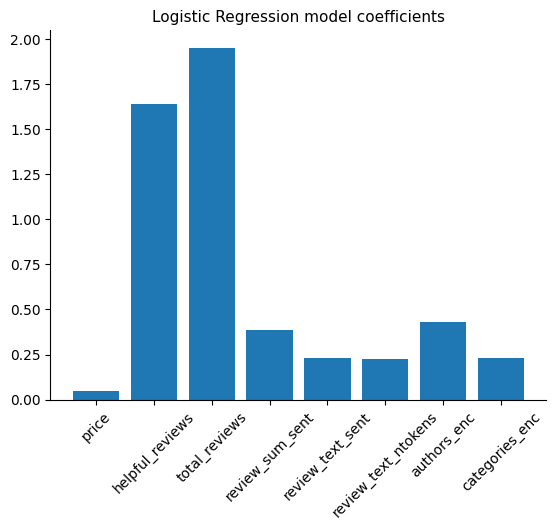

In [32]:
# Plot coefficients
plt.bar(X_train.columns, np.abs(model.coef_[0]))
plt.title("Logistic Regression model coefficients", fontsize=11)
plt.xticks(rotation=45)
sns.despine()
plt.show()

## Conclusion
The total number of reviews and the number of helpful reviews appear to be the most predictive features in this project. This aligns with the minimal impact that various processing methods applied to the categorical variables have had.